In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


import scipy.stats as stats 
from scipy.stats import chi2_contingency, boxcox

In [4]:
df = pd.read_csv('Maternal-risk-analized.csv')

In [7]:
df.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')

# PREDICCIÓN DE RIESGO MATERNAL CON ALGORITMO RANDOM FOREST PARA DATASET WEARABLE

Este cuaderno es la continuación del cuaderno 04-RF.risk-prediction porque hemos hecho un dataset nuevo que reprsente los datos del wearable, basándonos en la información de los datos de synthea. Además, este algoritmo incluye únicamente las medidas captadas por el wearable, por lo que no se incluye la edad en la predicción ni el entrenamiento. 

In [11]:
class_weight = {0:0.2, 1:0.5, 2:0.3}

In [13]:
x = df.drop(columns=['RiskLevel', 'Age'], axis=1)
y = df['RiskLevel']

In [15]:
#Separamos datos entre muestra de entrenamiento y muestra de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101, stratify=y)

In [17]:
classifier = RandomForestClassifier(class_weight=class_weight)

#Definimos hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [15, 30, 50, 75, 100, 150],
    'min_samples_split':[2,5,10,15,20],
    'min_samples_leaf': [3, 5, 7, 10,15], 
    'max_features': ['sqrt', 'log2', None, 0.6, 3], 
    'bootstrap': [True, False]
    }

#creamos objeto GridSearchCV
#Realizamos validación cruzada de 5 particiones (cv = 5)
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print('Mejores parámetros a usar:', grid_search.best_params_)
print('Mejor precisión:', grid_search.best_score_)

#Identificación del mejor modelo
best_forest = grid_search.best_estimator_

Mejores parámetros a usar: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 100}
Mejor precisión: 0.6931547619047619


In [23]:
forest_pred = grid_search.predict(X_test)

In [25]:
# Crear un nuevo modelo Random Forest con los mejores parámetros
final_model = RandomForestClassifier(
    n_estimators=50,
    criterion='entropy',
    max_depth=50,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='log2',
    bootstrap=True,
    random_state=42  # Para reproducibilidad
)

# Entrenar el modelo con los datos de entrenamiento
final_model.fit(X_train, y_train)

# Hacer predicciones con el modelo final
y_pred = final_model.predict(X_test)

# Evaluar el modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.97      0.84        70
           1       0.80      0.25      0.38        32
           2       0.83      0.85      0.84        34

    accuracy                           0.77       136
   macro avg       0.79      0.69      0.69       136
weighted avg       0.78      0.77      0.73       136



In [27]:
from sklearn.model_selection import cross_val_score

# Validación cruzada
scores = cross_val_score(final_model, X_train, y_train, cv=5)

print("Cross-validation scores:", scores)
print(f"Mean CV Accuracy: {scores.mean():.2f}")

Cross-validation scores: [0.671875   0.66666667 0.66666667 0.68253968 0.79365079]
Mean CV Accuracy: 0.70


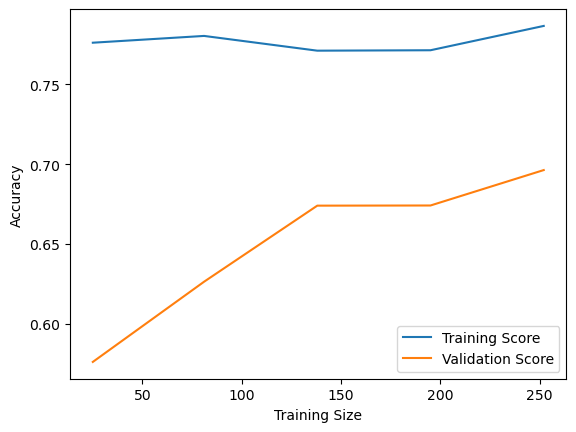

In [29]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(final_model, X_train, y_train, cv=5)

# Calcular medias
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Graficar
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

El modelo está algo sobrajustado al inicio, pero a medida que aumenta el tamaño del conjunto de entrenamiento, la brechaentre entrenamiento y validación disminuye. Esto sugiere que, con más datos, el modelo puede mejorar su capcidad de generalización. No está gravemente sobrejaustado pero podría beneficarsde de más datos o regularización. 

In [32]:
import joblib
joblib.dump(final_model, 'maternal-risk-RF-model-WEARABLE.pkl')
print("Modelo guardado como 'maternal-risk-RF-model-WEARABLE.pkl'")

Modelo guardado como 'maternal-risk-RF-model-WEARABLE.pkl'


## PRUEBA CON DATOS DEL WEARABLE CREADOS CON GRETEL.IA

In [35]:
wearabledf = pd.read_csv('wearable_MaternalRiskDatasetUnknownAge.csv')

In [37]:
import joblib

# Cargar el modelo guardado
model_path = 'maternal-risk-RF-model-WEARABLE.pkl'  # Cambia a la ruta donde esté el archivo si es necesario
loaded_model = joblib.load(model_path)
print("Modelo cargado exitosamente.")

Modelo cargado exitosamente.


In [39]:
column_rename_mapping = {
    'Glucose': 'BS',
    'SBP': 'SystolicBP',
    'DBP': 'DiastolicBP',
    'BodyTemperature': 'BodyTemp'
}
wearabledf = wearabledf.rename(columns=column_rename_mapping)
print(wearabledf.columns)

Index(['PATIENT', 'DATE', 'BMI', 'DiastolicBP', 'BS', 'HeartRate',
       'SystolicBP', 'TRIMESTER', 'BodyTemp'],
      dtype='object')


In [41]:
#Cargar el modelo desde el archivo
rf_model = joblib.load('maternal-risk-RF-model-WEARABLE.pkl')

In [43]:
features = ['SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
X = wearabledf[features]
wearabledf['Predicted_Risk'] = rf_model.predict(X)
print(wearabledf['Predicted_Risk'].head())

0    2
1    2
2    2
3    2
4    2
Name: Predicted_Risk, dtype: int64


In [45]:
wearabledf.head()

,PATIENT,DATE,BMI,DiastolicBP,BS,HeartRate,SystolicBP,TRIMESTER,BodyTemp,Predicted_Risk
0,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 10:34:58+00:00,24.7,71.178908,79.831179,114.838581,100.268811,1,37.374863,2
1,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 18:34:58+00:00,24.7,65.962812,74.859087,108.726190,92.726731,1,37.396294,2
2,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 02:34:58+00:00,24.7,70.005049,82.893106,114.925831,100.203023,1,37.305957,2
3,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 10:34:58+00:00,24.7,71.682904,83.399110,116.286471,101.138374,1,37.364837,2
4,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 18:34:58+00:00,24.7,62.492963,74.590061,106.666019,90.652381,1,37.322765,2


In [47]:
wearabledf.to_csv('UKNOWNAGE-wearable-maternal-risk-predictions.csv', index=False)

## ANÁLISIS DE LOS RESULTADOS 

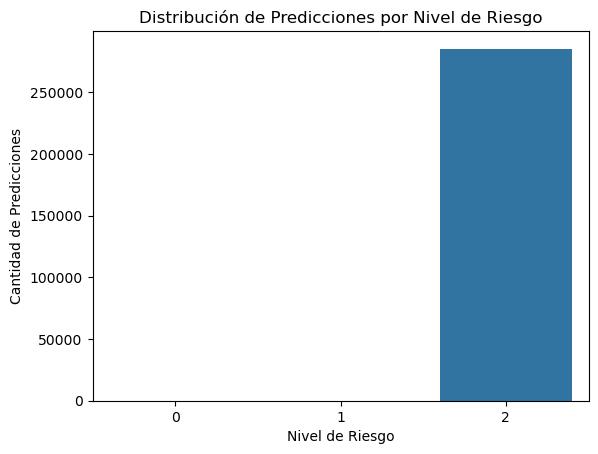

In [49]:
sns.countplot(data=wearabledf, x='Predicted_Risk', order=[0, 1, 2])
plt.title('Distribución de Predicciones por Nivel de Riesgo')
plt.xlabel('Nivel de Riesgo')
plt.ylabel('Cantidad de Predicciones')
plt.show()

## EVOLUCIÓN DEL RIESGO A LO LARGO DEL TIEMPO

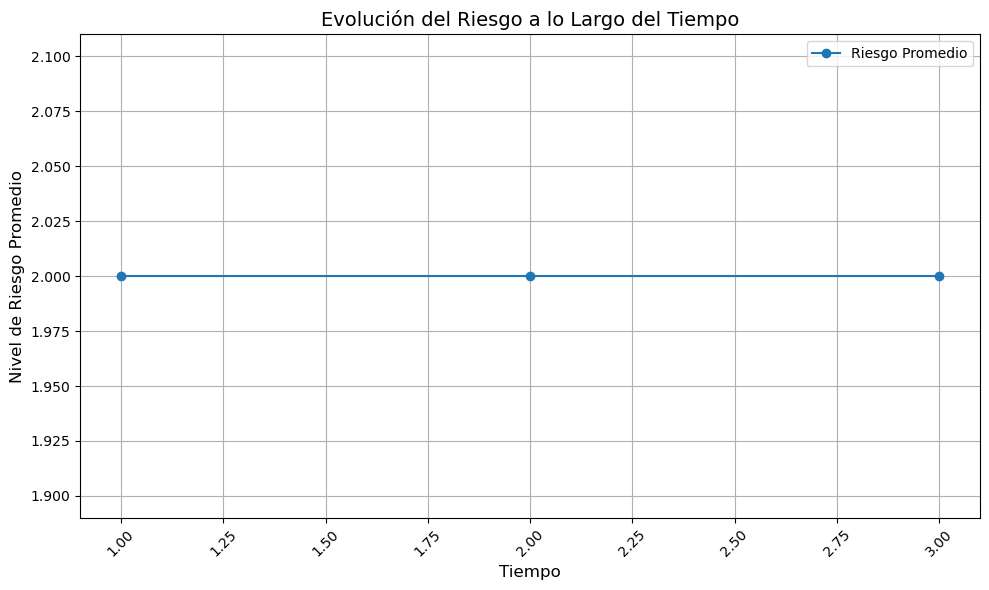

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
wearabledf['DATE'] = pd.to_datetime(wearabledf['DATE'])

#agrupamos por mes y calculamos el riesgo promedio
risk_over_time = wearabledf.groupby('TRIMESTER')['Predicted_Risk'].mean()
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(risk_over_time.index, risk_over_time.values, marker='o', linestyle='-', label='Riesgo Promedio')
plt.title('Evolución del Riesgo a lo Largo del Tiempo', fontsize=14)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Nivel de Riesgo Promedio', fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

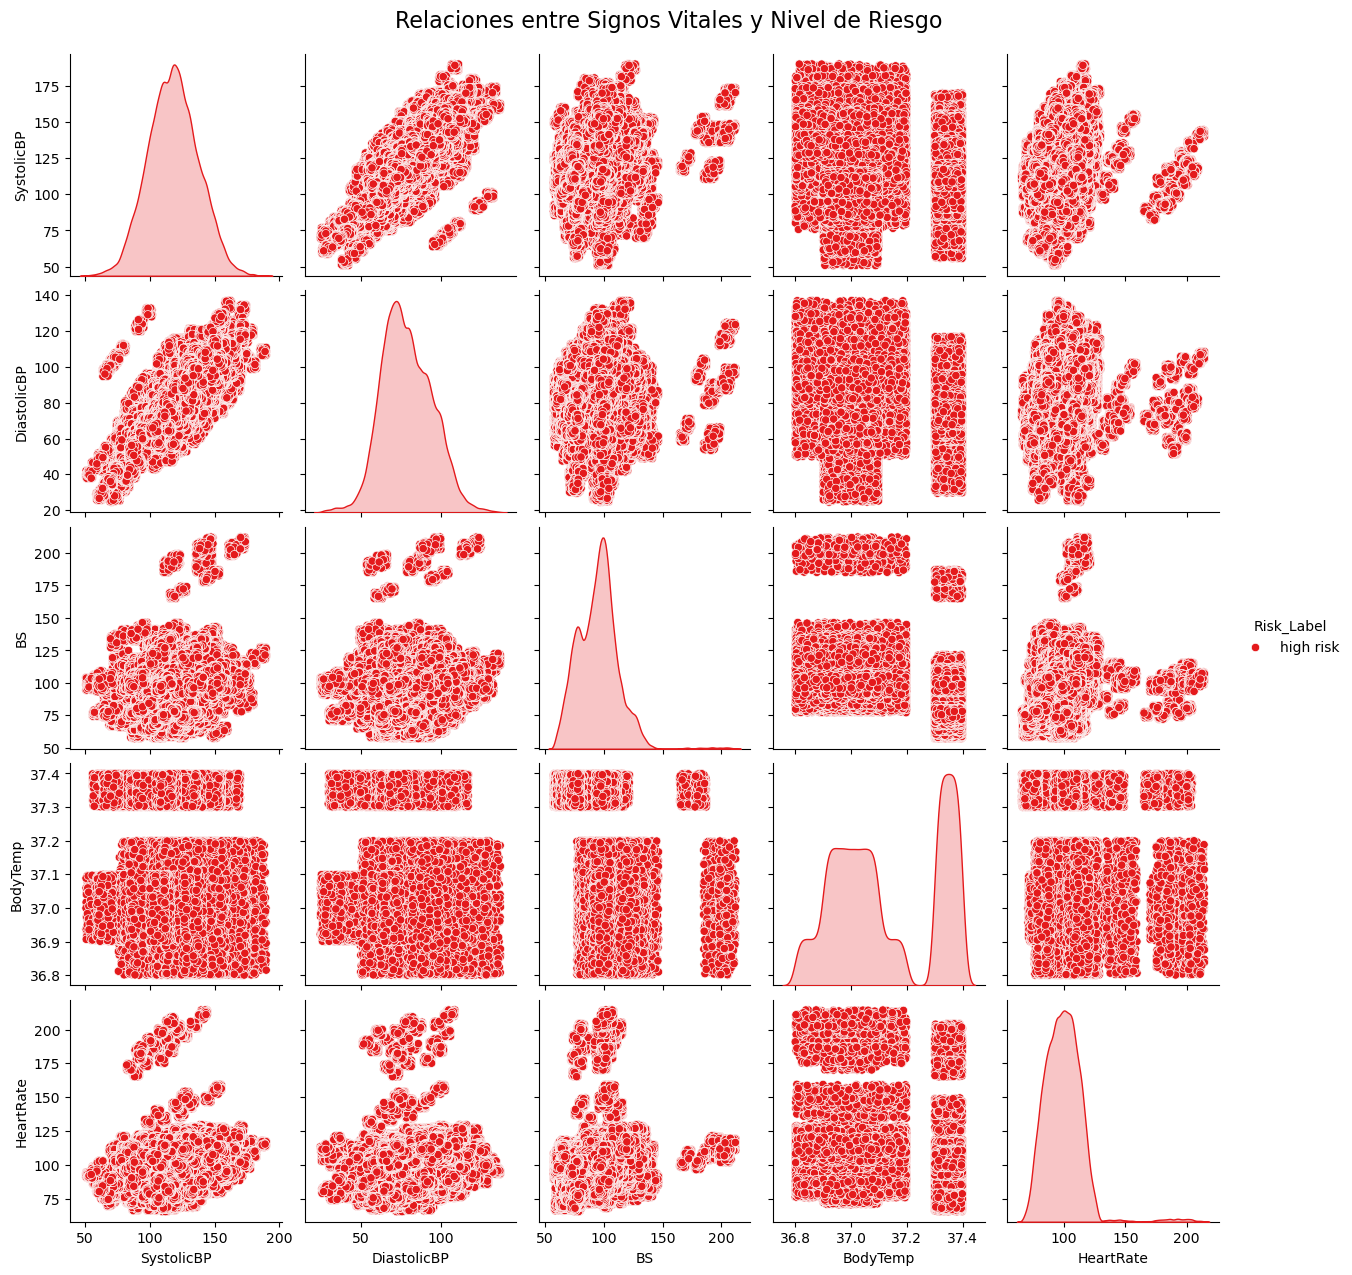

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapear las categorías numéricas a etiquetas
risk_mapping = {0: 'low risk', 1: 'mid risk', 2: 'high risk'}
wearabledf['Risk_Label'] = wearabledf['Predicted_Risk'].map(risk_mapping)
#signos vitales a analizar
vital_signs = ['SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'Risk_Label']

pairplot = sns.pairplot(
    data=wearabledf[vital_signs], 
    hue='Risk_Label', 
    palette='Set1', 
    diag_kind='kde', 
    height=2.5
    
)
pairplot.fig.suptitle("Relaciones entre Signos Vitales y Nivel de Riesgo", y=1.02, fontsize=16)
plt.show()

### DISTRIBUCIÓN DE LOS FACTORES DE RIESGO POR TRIMESTRES

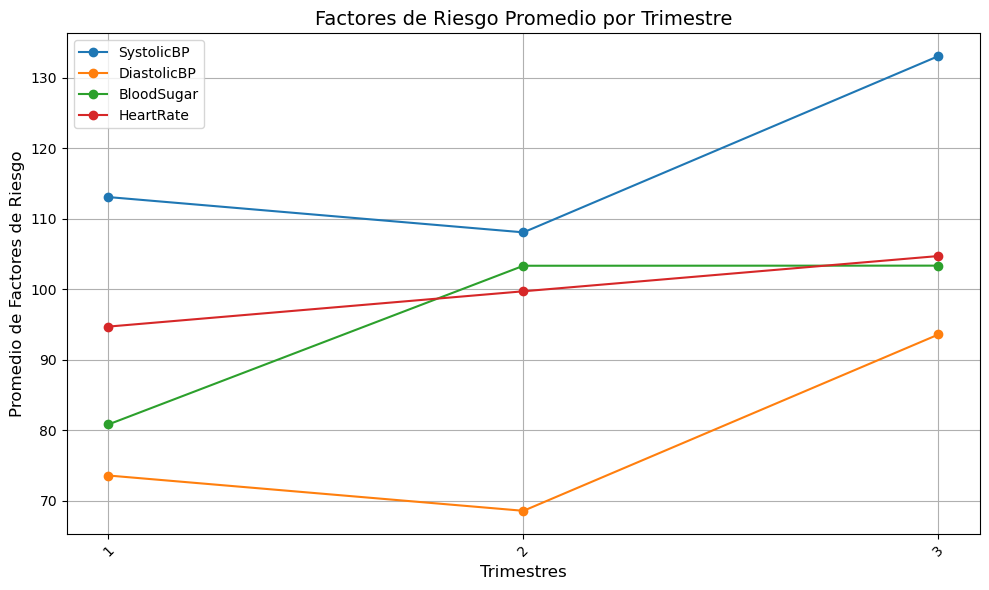

In [56]:
distribution = wearabledf.groupby('TRIMESTER').size() #Distribucion de datos por trimestre

#Analizamos factores específicos que contribuyen al riesgo
risk_factors_by_quarter= wearabledf.groupby('TRIMESTER')[['SystolicBP', 'DiastolicBP', 'BS', 'HeartRate']].mean() 

plt.figure(figsize=(10,6))

plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['SystolicBP'], marker = 'o', linestyle='-', label = 'SystolicBP')
plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['DiastolicBP'], marker = 'o', linestyle='-', label = 'DiastolicBP')
plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['BS'], marker = 'o', linestyle='-', label = 'BloodSugar')
plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['HeartRate'], marker = 'o', linestyle='-', label = 'HeartRate')

plt.title('Factores de Riesgo Promedio por Trimestre', fontsize=14)
plt.xlabel('Trimestres', fontsize=12)
plt.ylabel('Promedio de Factores de Riesgo', fontsize=12)
plt.grid(True)

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# PRUEBA CON DATASET WEARABLE CASO LÍMITE

Este dataset corresponde a datos biométricos capturados con un wearable de usuarias con preeclampsia y/o diabetes gestacional. 

In [20]:
extremeCase = pd.read_csv('wearable_MaternalRiskDataset_EXTREME_CASE.csv')

In [21]:
extremeCase

,PATIENT,DATE,BMI,DBP,Glucose,HeartRate,SBP,TRIMESTER,BodyTemperature
0,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 10:34:58+00:00,24.7,71.178908,79.831179,114.838581,100.268811,1,37.374863
1,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 18:34:58+00:00,24.7,65.962812,74.859087,108.726190,92.726731,1,37.396294
2,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 02:34:58+00:00,24.7,70.005049,82.893106,114.925831,100.203023,1,37.305957
3,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 10:34:58+00:00,24.7,71.682904,83.399110,116.286471,101.138374,1,37.364837
4,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 18:34:58+00:00,24.7,62.492963,74.590061,106.666019,90.652381,1,37.322765
...,...,...,...,...,...,...,...,...,...
285467,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-15 21:49:39+00:00,24.8,86.715237,118.954019,111.153341,126.668632,3,37.091396
285468,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 05:49:39+00:00,24.8,95.012159,119.079043,120.751634,133.532145,3,36.857251
285469,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 13:49:39+00:00,24.8,93.703150,117.198304,111.686933,127.233104,3,37.072783
285470,ff42db38-8a0b-7abc-a4c8-5d63504f4272,1997-01-16 21:49:39+00:00,24.8,87.916110,119.355192,111.534658,125.608165,3,37.136600


In [61]:
rf_model= joblib.load('maternal-risk-RF-model-WEARABLE.pkl')

In [67]:
column_rename_mapping = {
    'Glucose': 'BS',
    'SBP': 'SystolicBP',
    'DBP': 'DiastolicBP',
    'BodyTemperature': 'BodyTemp'
}
extremeCase = extremeCase.rename(columns=column_rename_mapping)
print(extremeCase.columns)

Index(['PATIENT', 'DATE', 'BMI', 'DiastolicBP', 'BS', 'HeartRate',
       'SystolicBP', 'TRIMESTER', 'BodyTemp'],
      dtype='object')


In [69]:
features = ['SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
X = extremeCase[features]
extremeCase['Predicted_Risk'] = rf_model.predict(X)


In [71]:
extremeCase.head()

,PATIENT,DATE,BMI,DiastolicBP,BS,HeartRate,SystolicBP,TRIMESTER,BodyTemp,Predicted_Risk
0,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 10:34:58+00:00,24.7,71.178908,79.831179,114.838581,100.268811,1,37.374863,2
1,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-10 18:34:58+00:00,24.7,65.962812,74.859087,108.726190,92.726731,1,37.396294,2
2,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 02:34:58+00:00,24.7,70.005049,82.893106,114.925831,100.203023,1,37.305957,2
3,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 10:34:58+00:00,24.7,71.682904,83.399110,116.286471,101.138374,1,37.364837,2
4,07d072de-e7d4-7b46-3fc4-89e59f71eeee,2002-12-11 18:34:58+00:00,24.7,62.492963,74.590061,106.666019,90.652381,1,37.322765,2


In [73]:
extremeCase.to_csv('extremeCaseMaternalPredictions-WEARABLE.csv', index = False)

## ANÁLISIS DE LOS RESULTADOS

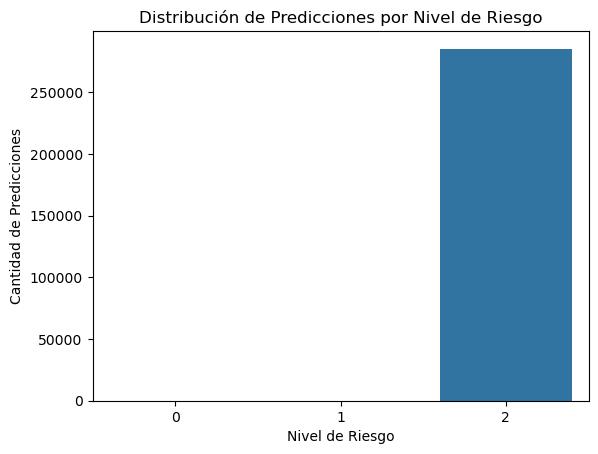

In [75]:
sns.countplot(data = extremeCase, x= 'Predicted_Risk', order = [0,1,2])
plt.title('Distribución de Predicciones por Nivel de Riesgo')
plt.xlabel('Nivel de Riesgo')
plt.ylabel('Cantidad de Predicciones')
plt.show()

## EVOLUCION A LO LARGO DEL TIEMPO

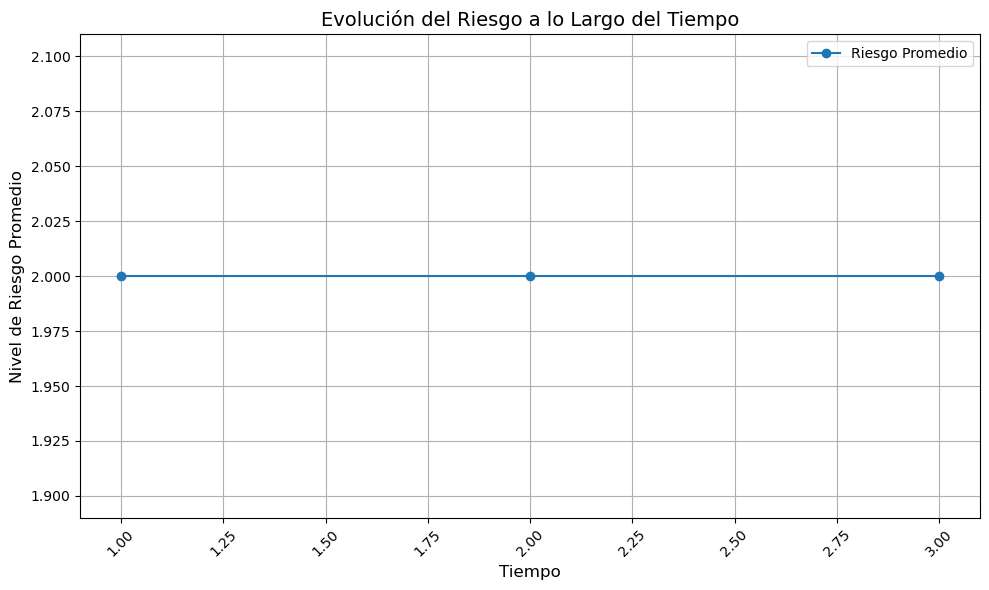

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
extremeCase['DATE'] = pd.to_datetime(extremeCase['DATE'])

#agrupamos por mes y calculamos el riesgo promedio
risk_over_time = extremeCase.groupby('TRIMESTER')['Predicted_Risk'].mean()
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(risk_over_time.index, risk_over_time.values, marker='o', linestyle='-', label='Riesgo Promedio')
plt.title('Evolución del Riesgo a lo Largo del Tiempo', fontsize=14)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Nivel de Riesgo Promedio', fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

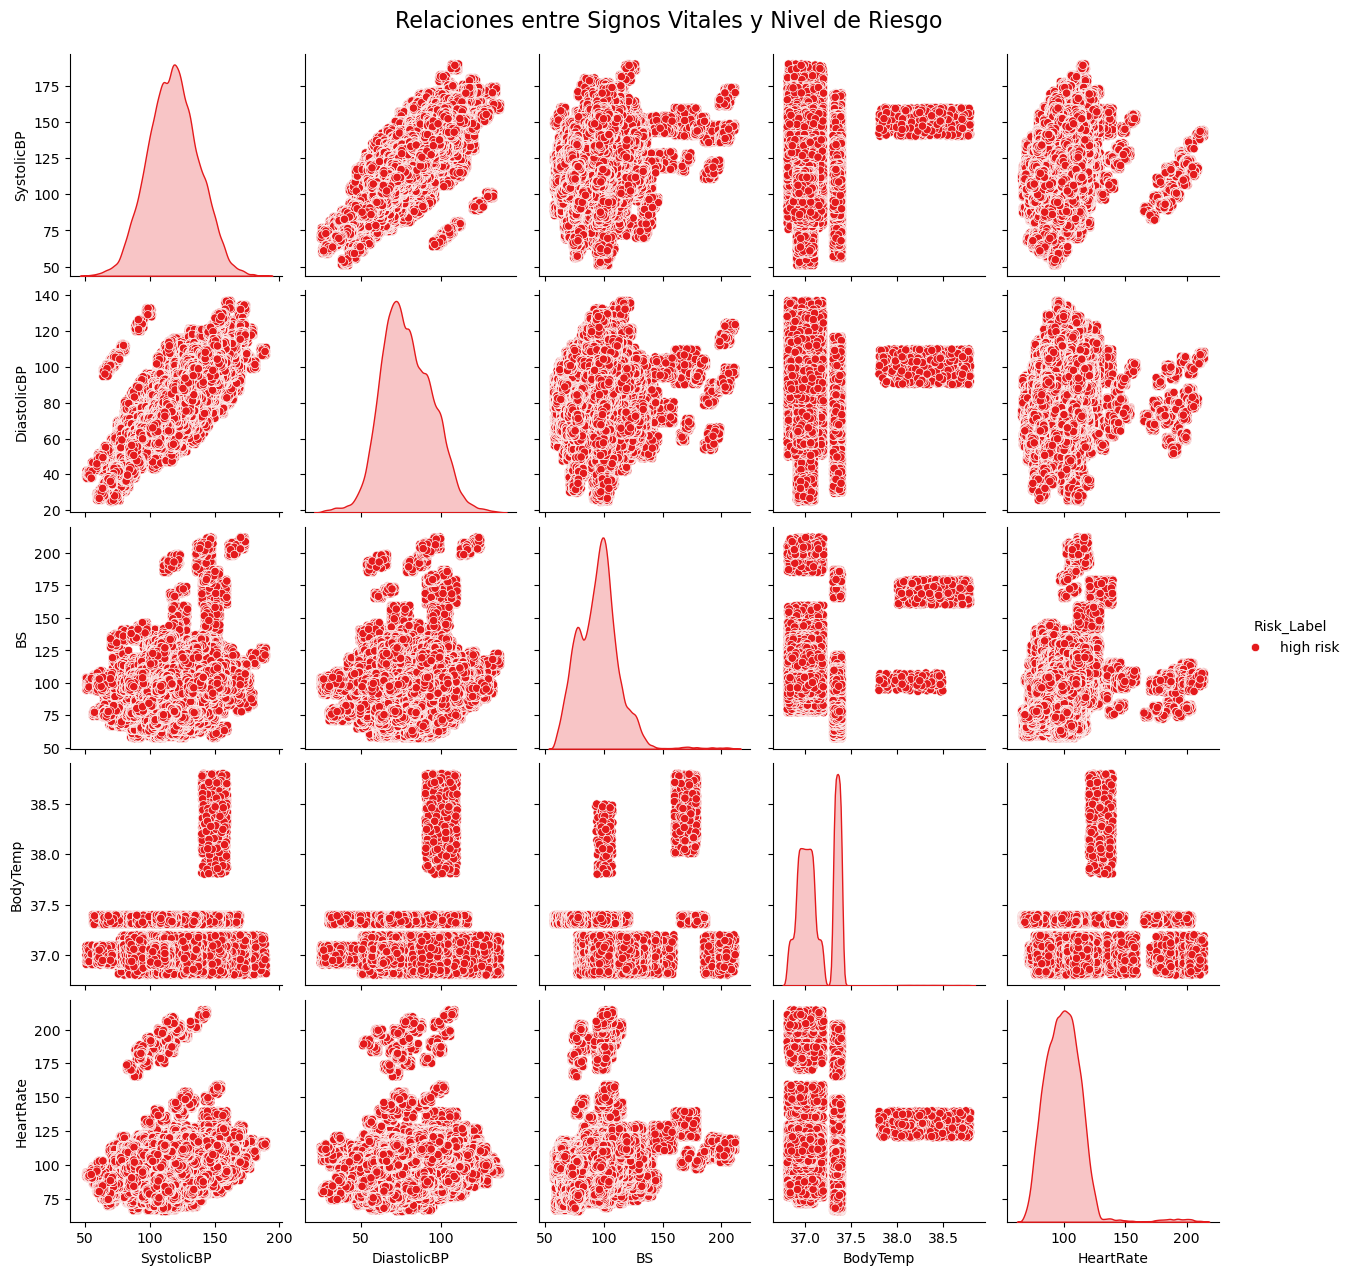

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mapear las categorías numéricas a etiquetas
risk_mapping = {0: 'low risk', 1: 'mid risk', 2: 'high risk'}
extremeCase['Risk_Label'] = extremeCase['Predicted_Risk'].map(risk_mapping)
#signos vitales a analizar
vital_signs = ['SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'Risk_Label']

pairplot = sns.pairplot(
    data=extremeCase[vital_signs], 
    hue='Risk_Label', 
    palette='Set1', 
    diag_kind='kde', 
    height=2.5
    
)
pairplot.fig.suptitle("Relaciones entre Signos Vitales y Nivel de Riesgo", y=1.02, fontsize=16)
plt.show()

### DISTRIBUCIÓN DEL RIESGO POR TRIMESTRES

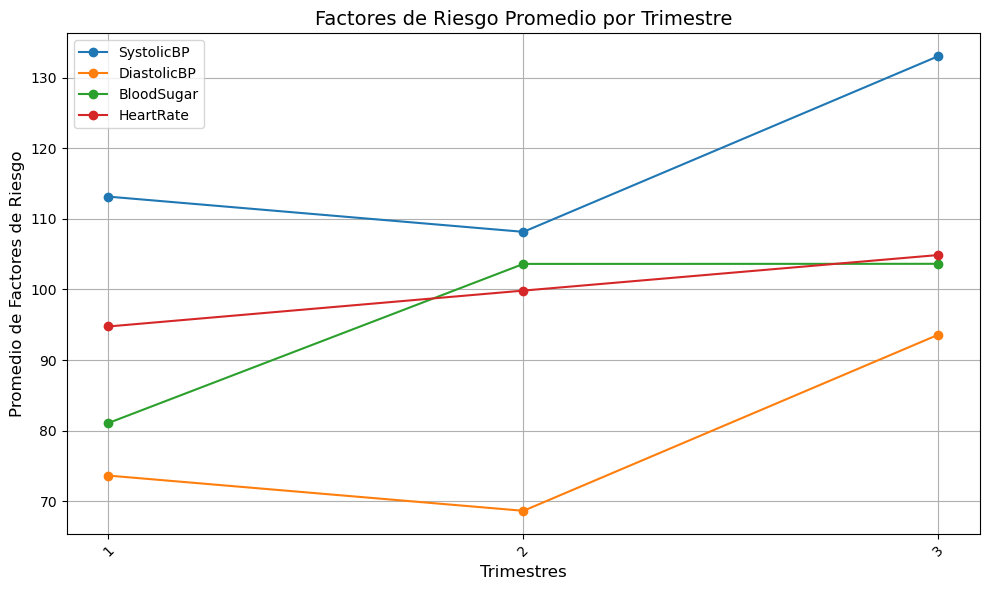

In [83]:
distribution = extremeCase.groupby('TRIMESTER').size() #Distribucion de datos por trimestre

#Analizamos factores específicos que contribuyen al riesgo
risk_factors_by_quarter= extremeCase.groupby('TRIMESTER')[['SystolicBP', 'DiastolicBP', 'BS', 'HeartRate']].mean() 

plt.figure(figsize=(10,6))

plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['SystolicBP'], marker = 'o', linestyle='-', label = 'SystolicBP')
plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['DiastolicBP'], marker = 'o', linestyle='-', label = 'DiastolicBP')
plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['BS'], marker = 'o', linestyle='-', label = 'BloodSugar')
plt.plot(risk_factors_by_quarter.index.astype(str), risk_factors_by_quarter['HeartRate'], marker = 'o', linestyle='-', label = 'HeartRate')

plt.title('Factores de Riesgo Promedio por Trimestre', fontsize=14)
plt.xlabel('Trimestres', fontsize=12)
plt.ylabel('Promedio de Factores de Riesgo', fontsize=12)
plt.grid(True)

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Tiene los mismos patrones que en el anterior caso, y que coinciden con la literatura médica. 